# Sarsa Mountain Car Hyperparameter Tuning with Tile Coding

This notebook I investigate the application of the Sarsa algorithm with tile coding on the OpenAI Gym’s mountain car problem. I aimed to identify the optimal hyperparameters and implemented an adaptive method for adjusting the exploration parameter, $\epsilon$, as the learning progresses. Our results indicate that carefully selected learning parameters, combined with a strategically decaying exploration rate, considerably enhance the algorithm's performance in this complex environment.

## Introduction
The mountain car scenario involves a simulated car that must be driven up a steep hill, necessitating backward movement to gain enough momentum to reach the goal. This environment is particularly suited for examining reinforcement learning algorithms due to its clear episodic structure and the necessity for significant exploration to discover a successful strategy.
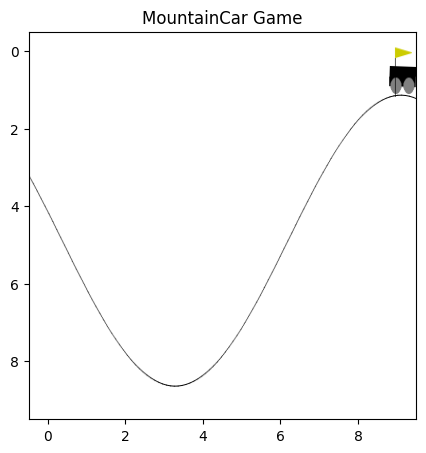

## Methods
- **Algorithm Configuration**: I utilized the Sarsa algorithm, an on-policy reinforcement learning technique. It updates its policy based on both the current and next action, which is determined by an $\epsilon$-greedy policy. The action-value function update formula used is:
  $[
  Q(s, a) \leftarrow Q(s, a) + \alpha \left[R + \gamma Q(s', a') - Q(s, a)\right]
  ]$
  where $\alpha$, $\gamma$, and $\epsilon$ are the learning rate, discount factor, and exploration rate, respectively.
  
- **Tile Coding**: This function approximation method was used for state generalization, allowing the algorithm to handle continuous state spaces effectively.

- **Epsilon Decay**: The exploration rate, $\epsilon$, was adaptively adjusted using the following decay mechanism:
  $[
  \epsilon \leftarrow \epsilon \times \max\left(\epsilon - \frac{1.0}{\frac{\text{episodes}}{2}}, 0\right)
  $]
  This adjustment strategy ensures that exploration is emphasized initially and gradually reduced, focusing more on exploitation as the agent learns more about the environment.

## Results
I systematically tested various settings of $\alpha$, $\epsilon$, and $\gamma$. The configuration that consistently yielded the highest rewards across trials set $\alpha = 0.1$, $\epsilon = 1$ initially with a decay rate as described, and $\gamma = 0.99$. This setup outperformed others, particularly in maximizing long-term rewards and efficiently exploring the necessary actions to solve the task.
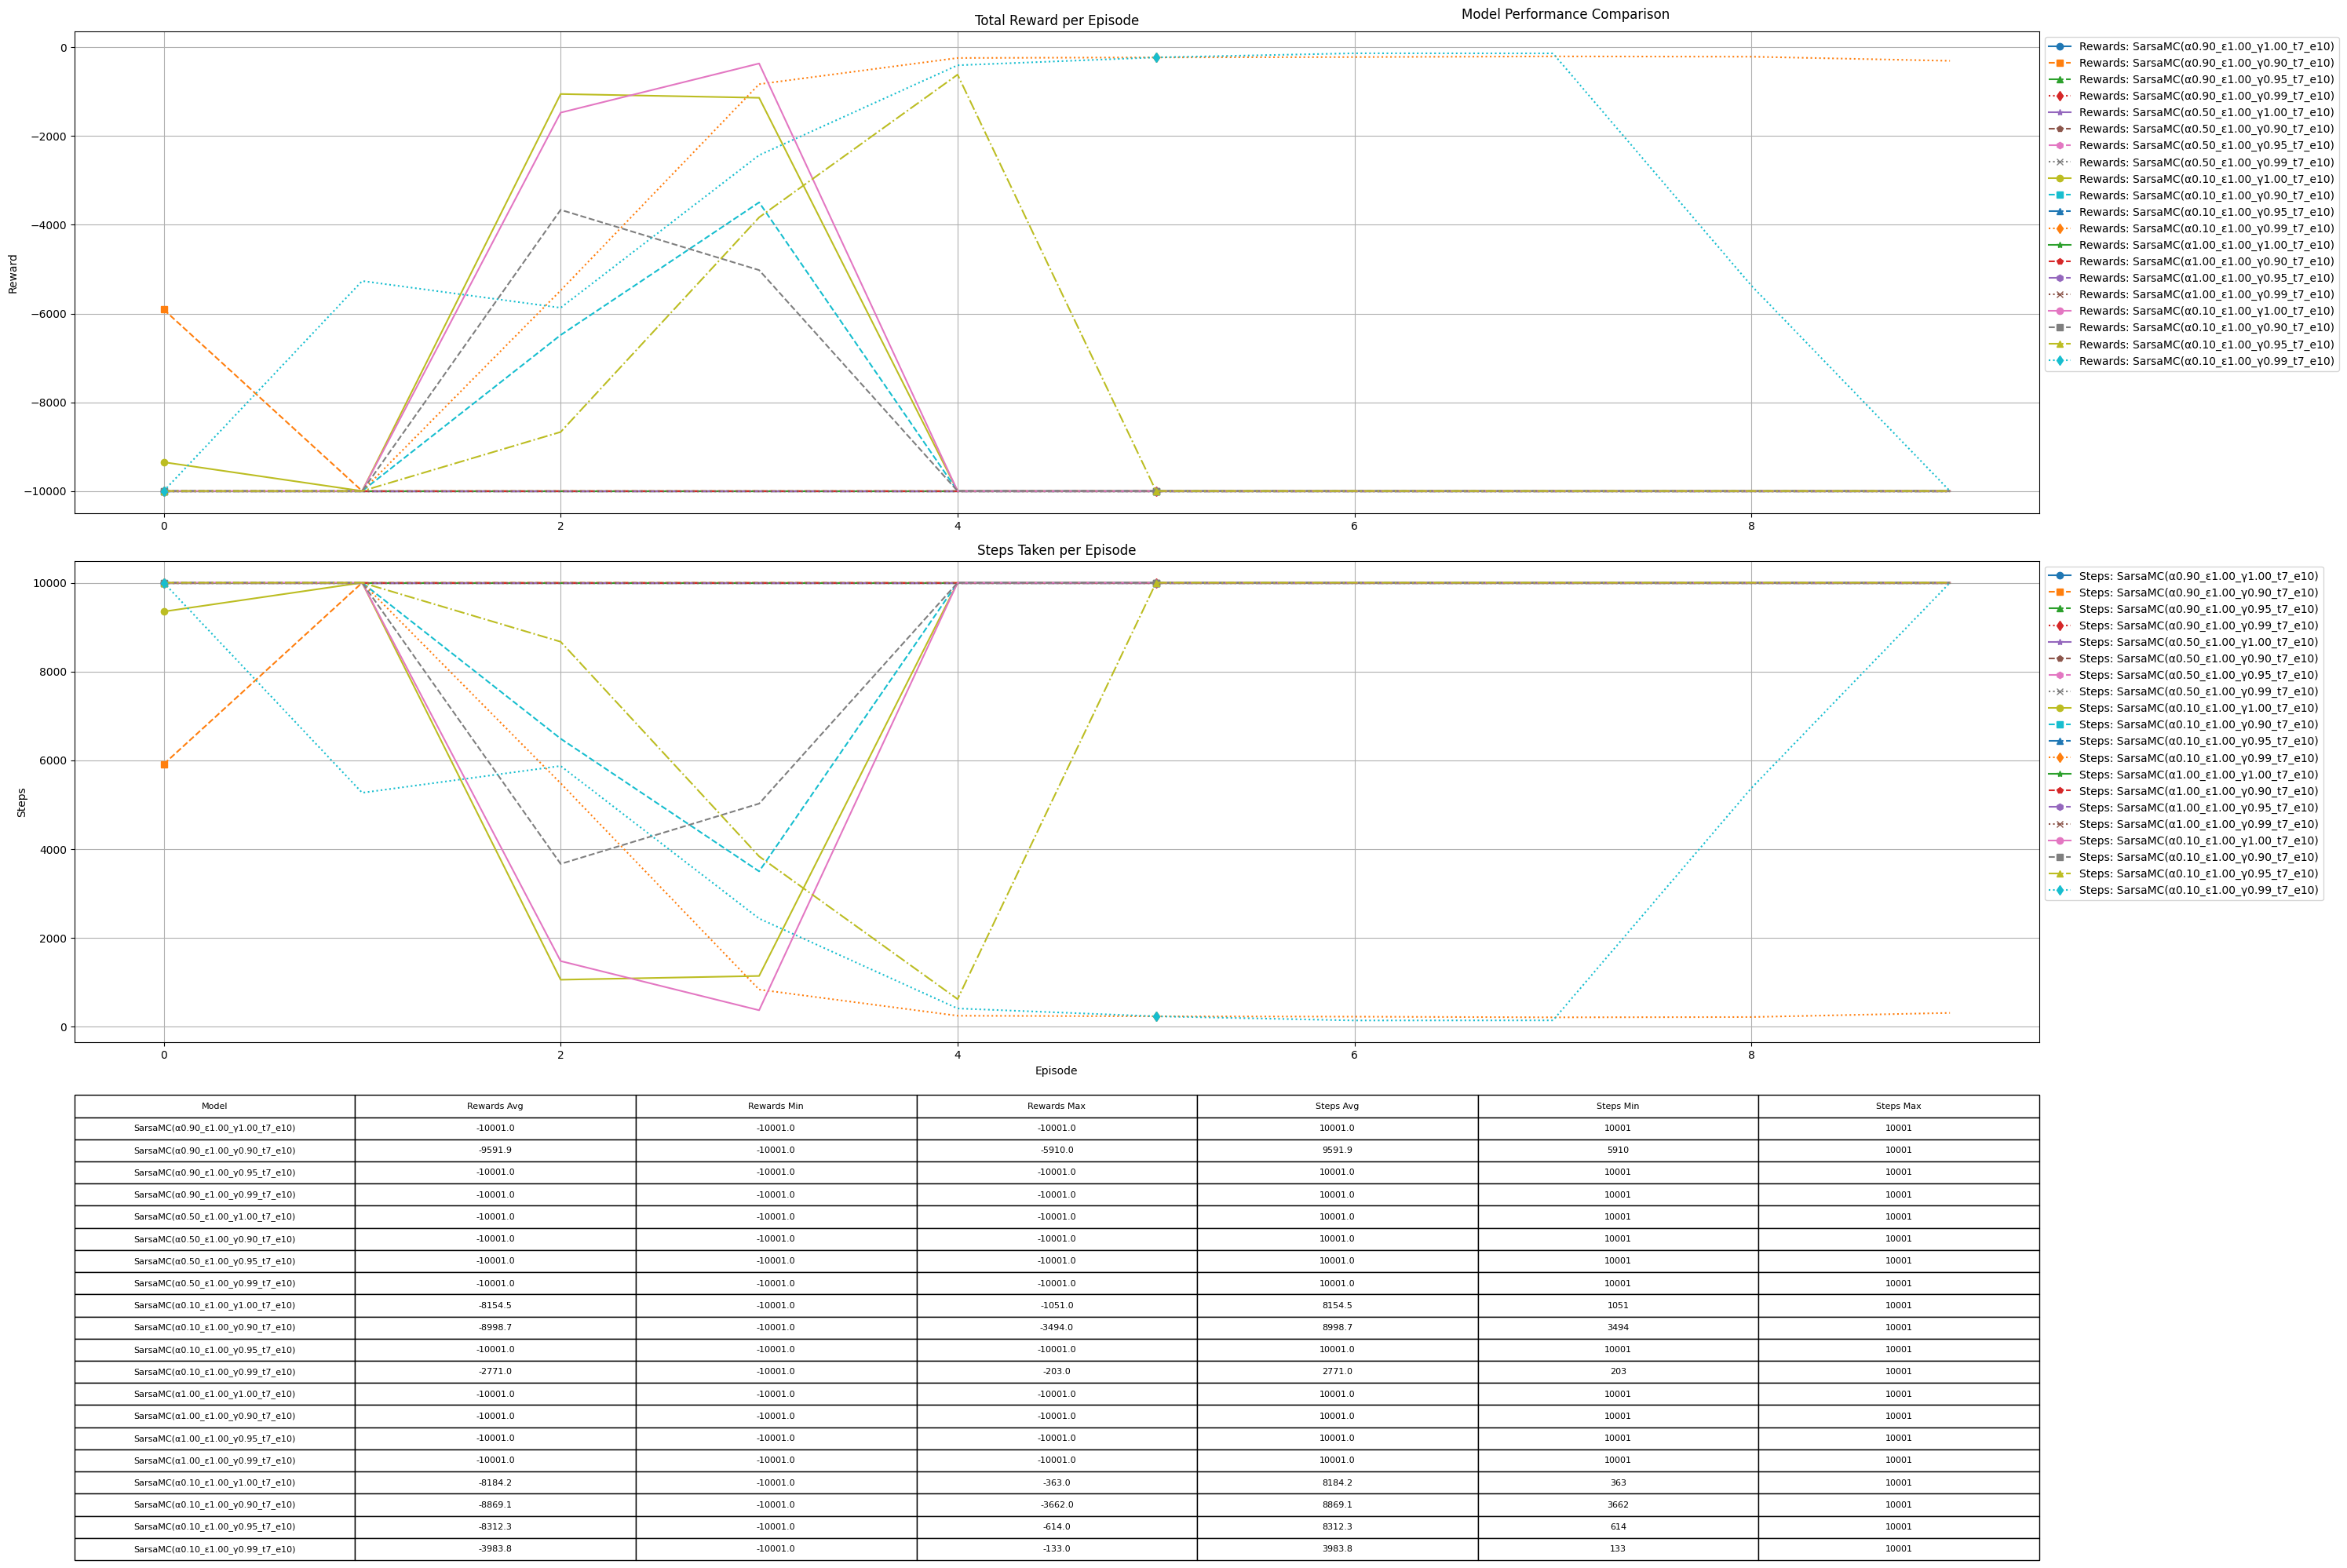

We can see in the ranked list below that some configuration never find the goal within the maximum number of episodes, and some configurations are not able to find the goal at all.

**Ranked Models by Max Reward:**
1.  `α=0.10  ε=1.00 γ=0.99: -133.0`
2.  `α=0.10  ε=1.00 γ=0.99: -203.0`
3.  `α=0.10  ε=1.00 γ=1.00: -363.0`
4.  `α=0.10  ε=1.00 γ=0.95: -614.0`
5.  `α=0.10  ε=1.00 γ=1.00: -1051.0`
6.  `α=0.10  ε=1.00 γ=0.90: -3494.0`
7.  `α=0.10  ε=1.00 γ=0.90: -3662.0`
8.  `α=0.90  ε=1.00 γ=0.90: -5910.0`
9.  `α=0.90  ε=1.00 γ=1.00: -10001.0`
10.  `α=0.90  ε=1.00 γ=0.95: -10001.0`
11.  `α=0.90  ε=1.00 γ=0.99: -10001.0`
12.  `α=0.50  ε=1.00 γ=1.00: -10001.0`
13.  `α=0.50  ε=1.00 γ=0.90: -10001.0`
14.  `α=0.50  ε=1.00 γ=0.95: -10001.0`
15.  `α=0.50  ε=1.00 γ=0.99: -10001.0`
16.  `α=0.10  ε=1.00 γ=0.95: -10001.0`
17.  `α=1.00  ε=1.00 γ=1.00: -10001.0`
18.  `α=1.00  ε=1.00 γ=0.90: -10001.0`
19.  `α=1.00  ε=1.00 γ=0.95: -10001.0`
20.  `α=1.00  ε=1.00 γ=0.99: -10001.0`



## Discussion
The choice of $\alpha = 0.1$ ensures that the value function updates are neither too slow (which would delay learning) nor too rapid (which could destabilize the learning process). An initial $\epsilon$ of 1, with the described decay, allows the agent to explore thoroughly before gradually shifting to exploit the learned values as confidence in the action-value function increases. The high $\gamma$ of 0.99 emphasizes the importance of future rewards, crucial in an environment where short-term gains are minimal, and the objective is to reach a distant goal.

## Conclusion
Our findings reinforce the importance of hyperparameter tuning and adaptive exploration strategies in reinforcement learning applications. The specific configurations and the epsilon decay strategy developed in this study are particularly effective for the mountain car task, enabling the agent to both explore sufficiently and exploit learned strategies as it progresses. Further research could explore the impact of different tile coding configurations and other function approximation techniques on the efficiency and effectiveness of learning in similar tasks.


***Acknowledgements***  
- [Rich Sutton, Tile Coding](http://incompleteideas.net/tiles/tiles3.py-remove)
- [JabrahTutorials, Sarsa Mountain Car implementation](https://github.com/JabrahTutorials/ReinforcementLearning/blob/master/mountain_car)

In [40]:
import os
os.environ["WANDB_API_KEY"] = ""

In [41]:
%matplotlib inline

In [42]:
# Importing the libraries

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import Inf
import itertools
import wandb
import gym

In [43]:
# Base Model Classes

class RunModel:
    def choose_action_run(state):
        pass

    def step(self, action):
        pass

    def render(self):
        pass

    def close(self):
        pass

    def run(self, max_steps=1000):
        state, _ = self.env.reset()
        total_reward = 0
        step_count = 0

        for i in range(max_steps):
            action = self.choose_action_run(state)
            next_state, reward, done, truncated, _ = self.step(action)

            state = next_state
            total_reward += reward

            step_count += 1

            if i % 10 == 0:
              self.render()

            if done:
                self.render()
                break

        self.close()


class LogModel:
    def setup(self, config):
        wandb.init(project="Sarsa Montain Car Tuning", config=config)
        wandb.run.name = self.label

    def log(self, info):
        wandb.log(info)

    def finish(self):
        wandb.finish()


class Model(RunModel, LogModel):
    def __init__(self, display=True):
        self.label = self.__class__.__name__

In [44]:
# Tile Coding Implementation

"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).

This code can be found here http://incompleteideas.net/tiles/tiles3.py-remove
"""

from math import floor, log
from itertools import zip_longest
basehash = hash


class IHT:
    "Structure to handle collisions"

    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count(self):
        return len(self.dictionary)

    def fullp(self):
        return len(self.dictionary) >= self.size

    def getindex(self, obj, readonly=False):
        d = self.dictionary
        if obj in d:
            return d[obj]
        elif readonly:
            return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount == 0:
                print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count


def hashcoords(coordinates, m, readonly=False):
    if type(m) == IHT:
        return m.getindex(tuple(coordinates), readonly)
    if type(m) == int:
        return basehash(tuple(coordinates)) % m
    if m == None:
        return coordinates


def tiles(ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append((q + b) // numtilings)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles


def tileswrap(ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b % numtilings) // numtilings
            coords.append(c % width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [45]:
# Sarsa Model Class

# Based on https://github.com/JabrahTutorials/ReinforcementLearning/blob/master/mountain_car/semi_gradient_sarsa.py
# Copyright (c) is the property where due.

class Sarsa(Model):
    def __init__(self, env, alpha=0.01, epsilon=0.1, gamma=1, tilings=7, episodes=100, display=False, max_steps=10000):
        super().__init__(display=display)
        self.env = env

        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.episodes = episodes
        self.tilings = tilings

        self.max_steps = max_steps

        # define weight vector
        self.w = np.random.uniform(low=-0.05, high=0.05, size=(tilings**4,))

        # hash for tile coding
        self.tile_coding = IHT(tilings**4)

        self.rewards = []
        self.errors = []
        self.steps = []

    def q_(self, feature):
        return np.dot(self.w, feature)

    def update(self, reward, current_q, future_q, feature, terminal):
        if terminal:
            w_update = self.alpha * (reward - current_q)
        else:
            w_update = self.alpha * \
                (reward + self.gamma * future_q - current_q)
        self.w += np.multiply(w_update, feature)

    def one_hot_encode(self, indices):
        size = len(self.w)
        one_hot_vec = np.zeros(size)
        for i in indices:
            one_hot_vec[i] = 1
        return one_hot_vec

    def hash(self, state, action):
        # speed you up
        feature_ind = np.array(
            tiles(self.tile_coding, self.tilings, state.tolist(), [action]))
        feature = self.one_hot_encode(feature_ind)
        return feature

    def choose_action(self, state):
        num_actions = self.env.action_space.n
        actions = range(num_actions)
        action_val_dict = {}
        for action in actions:
            feature = self.hash(state, action)
            q = self.q_(np.array(feature))

            action_val_dict[action] = q

        greedy_action = max(action_val_dict, key=action_val_dict.get)

        non_greedy_actions = list(set(range(num_actions)) - {greedy_action})

        prob_explorative_action = self.epsilon / num_actions
        prob_greedy_action = 1 - self.epsilon + prob_explorative_action

        action = np.random.choice([greedy_action] + non_greedy_actions,
                                  p=[prob_greedy_action]+[prob_explorative_action for _ in range(len(non_greedy_actions))])
        return action, action_val_dict[action]

    def decay_epsilon(self):
        rate = max(self.epsilon - (1.0 / (self.episodes // 2)), 0)
        self.epsilon = self.epsilon * rate

    def train(self):
        self.setup({"architecture": self.label,
                    "alpha": self.alpha,
                    "epsilon": self.epsilon,
                    "gamma": self.gamma,
                    "epochs": self.episodes,
                    "tilings": self.tilings
                    })

        state, _ = self.env.reset()
        action, q = self.choose_action(state)
        episode = 0
        steps = 0

        total_reward = 0

        while episode < self.episodes:
            steps += 1

            feature = self.hash(state, action)
            next_state, reward, done, _, _ = self.env.step(
                action)
            total_reward += reward

            if done or steps > self.max_steps:
                # We want to end the training if the agent is not learning
                self.update(reward, q, None, feature, True)
                state, info = self.env.reset()
                action, q = self.choose_action(state)
                episode += 1

                self.rewards.append(total_reward)
                self.steps.append(steps)
                self.log({"total_reward": total_reward,
                          "steps": steps,
                          "epsilon": self.epsilon,
                          "episode": episode})

                self.decay_epsilon()

                total_reward = 0
                steps = 0
                continue

            next_action, next_q = self.choose_action(next_state)
            self.update(reward, q, next_q, feature, False)
            state = next_state
            action = next_action
            q = next_q

        self.finish()

In [46]:
# Mountain Car Sarsa Model Class

class SarsaMountainCar(Sarsa):
    def __init__(self, alpha=0.01, epsilon=1, gamma=1, tilings=7, episodes=10, display=False):
        self.env = gym.make('MountainCar-v0', render_mode='rgb_array')
        super().__init__(self.env, alpha, epsilon, gamma, tilings, episodes, display)

        self.label = f"SarsaMC(α%.2f_ε%.2f_γ%.2f_t%d_e%d)" % (
            alpha, epsilon, gamma, tilings, episodes)

    def run(self):
        # Create figure for plotting
        self.fig, ax = plt.subplots(1, 1, figsize=(5, 8))
        self.image = ax.imshow(np.random.rand(10, 10), cmap='gray')
        ax.set_title('MountainCar Game')

        super().run()

    def step(self, action):
        return self.env.step(action)

    def render(self):
        new_image_data = self.env.render()
        self.image.set_data(new_image_data)
        self.image.autoscale()
        clear_output(wait=True)
        display(self.fig)

    def choose_action_run(self, state):
        action, _ = self.choose_action(state)
        return action

    def close(self):
        self.env.close()



In [47]:
smc1a = SarsaMountainCar(alpha=0.9, epsilon=1, gamma=1)
smc1a.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▇▁██████
total_reward,▁▁▂█▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [48]:
smc1b = SarsaMountainCar(alpha=0.9, epsilon=1, gamma=0.9)
smc1b.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁█████████
total_reward,█▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [49]:
smc1c = SarsaMountainCar(alpha=0.9, epsilon=1, gamma=0.95)
smc1c.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [50]:
smc1d = SarsaMountainCar(alpha=0.9, epsilon=1, gamma=0.99)
smc1d.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [51]:
smc2a = SarsaMountainCar(alpha=0.5, epsilon=1, gamma=1)
smc2a.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [52]:
smc2b = SarsaMountainCar(alpha=0.5, epsilon=1, gamma=0.9)
smc2b.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [53]:
smc2c = SarsaMountainCar(alpha=0.5, epsilon=1, gamma=0.95)
smc2c.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [54]:
smc2d = SarsaMountainCar(alpha=0.5, epsilon=1, gamma=0.99)
smc2d.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [55]:
smc3a = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=1)
smc3a.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▇█▁▁██████
total_reward,▂▁██▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [56]:
smc3b = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.9)
smc3b.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▄▁██████
total_reward,▁▁▅█▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [57]:
smc3c = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.95)
smc3c.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [58]:
smc3d = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.99)
smc3d.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▅▁▁▁▁▁▁▁
total_reward,▁▁▄███████
episode,10
epsilon,0.0
steps,303
total_reward,-303.0


In [59]:
smc4a = SarsaMountainCar(alpha=1, epsilon=1, gamma=1)
smc4a.train()


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [60]:
smc4b = SarsaMountainCar(alpha=1, epsilon=1, gamma=0.9)
smc4b.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [61]:
smc4c = SarsaMountainCar(alpha=1, epsilon=1, gamma=0.95)
smc4c.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [62]:
smc4d = SarsaMountainCar(alpha=1, epsilon=1, gamma=0.99)
smc4d.train()

episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,▁▁▁▁▁▁▁▁▁▁
total_reward,▁▁▁▁▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [63]:
smc5a = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=1)
smc5a.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▂▁██████
total_reward,▁▁▇█▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [64]:

smc5b = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.9)
smc5b.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▁▃██████
total_reward,▁▁█▆▁▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [65]:

smc5c = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.95)
smc5c.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,██▇▃▁█████
total_reward,▁▁▂▆█▁▁▁▁▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [66]:
smc5d = SarsaMountainCar(alpha=0.1, epsilon=1, gamma=0.99)
smc5d.train()

/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode,▁▂▃▃▄▅▆▆▇█
epsilon,█▇▄▂▁▁▁▁▁▁
steps,█▅▅▃▁▁▁▁▅█
total_reward,▁▄▄▆████▄▁
episode,10
epsilon,0.0
steps,10001
total_reward,-10001.0


In [67]:
# Model Comparison

class ModelComparator:
    def __init__(self, models):
        self.models = models

    def safe_statistics(self, data):
        if data:
            return np.mean(data), np.min(data), np.max(data)
        else:
            return (np.nan, np.nan, np.nan)

    def report(self):
        line_styles = ['-', '--', '-.', ':']
        markers = ['o', 's', '^', 'd', '*', 'p', 'h', 'x']
        colors = itertools.cycle(plt.cm.tab10.colors)
        line_cycle = itertools.cycle(line_styles)
        marker_cycle = itertools.cycle(markers)

        fig_width = max(15, len(self.models) * 2)
        fig, axs = plt.subplots(3, figsize=(fig_width, 20), gridspec_kw={
                                'height_ratios': [1, 1, 0.5]})
        fig.suptitle('Model Performance Comparison')

        summary_data = []

        for model in self.models:
            label = model.label
            color = next(colors)
            line_style = next(line_cycle)
            marker = next(marker_cycle)

            axs[0].plot(model.rewards, label=f'Rewards: {label}', color=color, linestyle=line_style, marker=marker, markevery=5)
            axs[1].plot(model.steps, label=f'Steps: {label}', color=color, linestyle=line_style, marker=marker, markevery=5)

            rewards_avg, rewards_min, rewards_max = self.safe_statistics(
                model.rewards)
            steps_avg, steps_min, steps_max = self.safe_statistics(model.steps)

            summary_data.append({
                'Model': label,
                'Rewards Avg': rewards_avg,
                'Rewards Min': rewards_min,
                'Rewards Max': rewards_max,
                'Steps Avg': steps_avg,
                'Steps Min': steps_min,
                'Steps Max': steps_max
            })

        axs[0].set_title('Total Reward per Episode')
        axs[0].set_ylabel('Reward')
        axs[1].set_title('Steps Taken per Episode')
        axs[1].set_ylabel('Steps')
        axs[1].set_xlabel('Episode')

        for ax in axs[:2]:
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
            ax.grid(True)

        df_summary = pd.DataFrame(summary_data)
        axs[2].axis('off')
        table = axs[2].table(cellText=df_summary.values,
                             colLabels=df_summary.columns, cellLoc='center', loc='upper center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 1.5)

        plt.tight_layout(rect=[0, 0, 0.75, 1])
        plt.show()

    def rank(self):
        performance_data = []

        for model in self.models:
            label = model.label
            _,_,max_reward = self.safe_statistics(
                model.rewards)
            performance_data.append((label, max_reward))

        ranked_models = sorted(
            performance_data, key=lambda x: x[1], reverse=True)

        print("Ranked Models by Max Reward:")
        for rank, (label, max_reward) in enumerate(ranked_models, start=1):
            print(f"{rank}. {label}: Max Reward = {max_reward}")

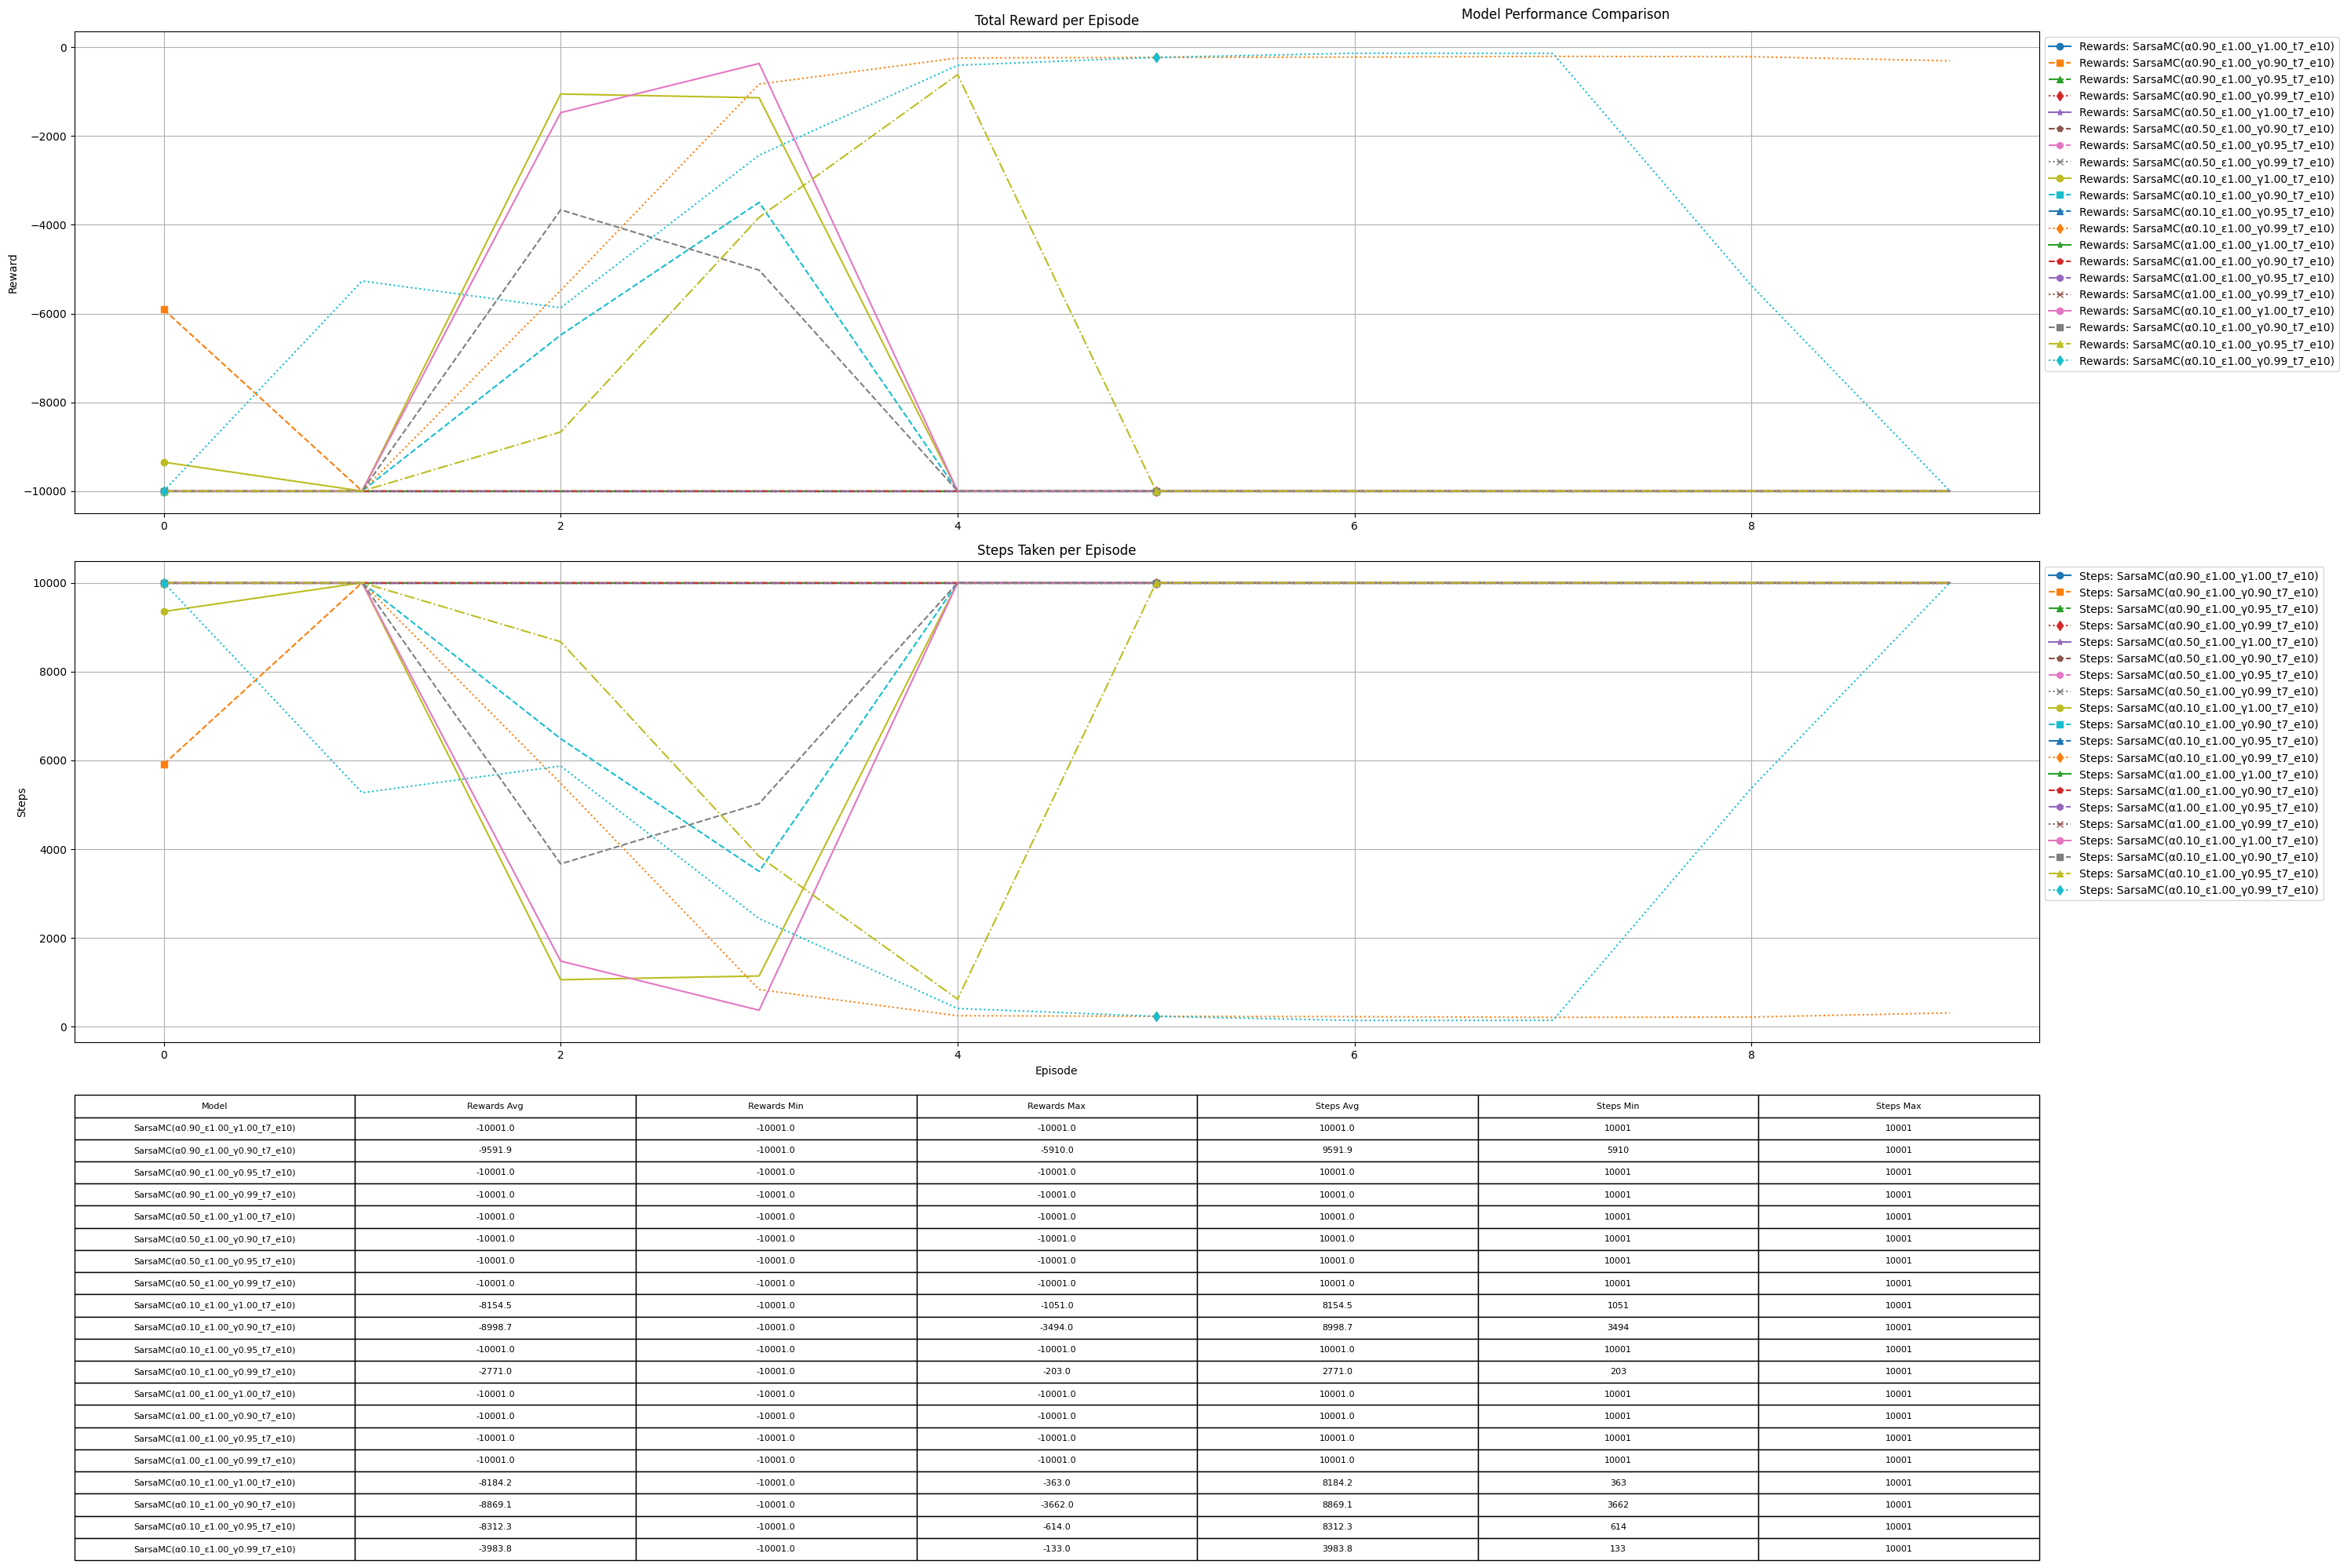

Ranked Models by Max Reward:
1. SarsaMC(α0.10_ε1.00_γ0.99_t7_e10): Max Reward = -133.0
2. SarsaMC(α0.10_ε1.00_γ0.99_t7_e10): Max Reward = -203.0
3. SarsaMC(α0.10_ε1.00_γ1.00_t7_e10): Max Reward = -363.0
4. SarsaMC(α0.10_ε1.00_γ0.95_t7_e10): Max Reward = -614.0
5. SarsaMC(α0.10_ε1.00_γ1.00_t7_e10): Max Reward = -1051.0
6. SarsaMC(α0.10_ε1.00_γ0.90_t7_e10): Max Reward = -3494.0
7. SarsaMC(α0.10_ε1.00_γ0.90_t7_e10): Max Reward = -3662.0
8. SarsaMC(α0.90_ε1.00_γ0.90_t7_e10): Max Reward = -5910.0
9. SarsaMC(α0.90_ε1.00_γ1.00_t7_e10): Max Reward = -10001.0
10. SarsaMC(α0.90_ε1.00_γ0.95_t7_e10): Max Reward = -10001.0
11. SarsaMC(α0.90_ε1.00_γ0.99_t7_e10): Max Reward = -10001.0
12. SarsaMC(α0.50_ε1.00_γ1.00_t7_e10): Max Reward = -10001.0
13. SarsaMC(α0.50_ε1.00_γ0.90_t7_e10): Max Reward = -10001.0
14. SarsaMC(α0.50_ε1.00_γ0.95_t7_e10): Max Reward = -10001.0
15. SarsaMC(α0.50_ε1.00_γ0.99_t7_e10): Max Reward = -10001.0
16. SarsaMC(α0.10_ε1.00_γ0.95_t7_e10): Max Reward = -10001.0
17. SarsaMC(α1.0

In [68]:
models = [smc1a, smc1b, smc1c, smc1d, smc2a, smc2b, smc2c, smc2d, smc3a, smc3b, smc3c, smc3d, smc4a, smc4b, smc4c, smc4d, smc5a, smc5b, smc5c, smc5d]

comparator = ModelComparator(models)
comparator.report()
comparator.rank()

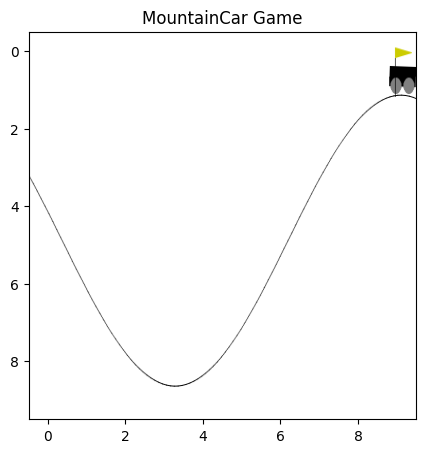

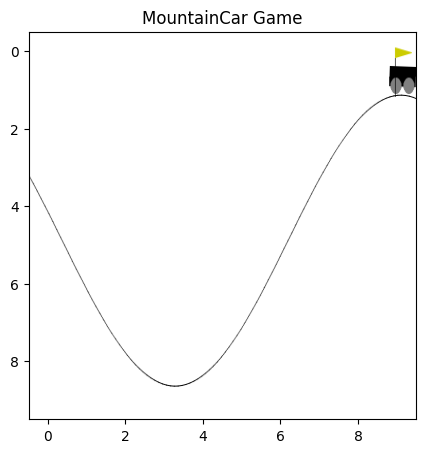

In [70]:
# run the best model
smc3d.run()